In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [32]:
credentials={
  "apikey": "B8NlKr90RfmyJtDX6CpdFyHmo1Oa3qHtKfCHiZDy1FIw",
  "cos_hmac_keys": {
    "access_key_id": "aa665b9f59da40aaa49ea316001bb7df",
    "secret_access_key": "43d31cf67a00169c7357ed4211b28e722e1a385a353ffe6c"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key aa665b9f-59da-40aa-a49e-a316001bb7df",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/ba7188f6f04a428f8b489d924ac4f9e7::serviceid:ServiceId-98f2dbf4-2007-448c-9185-d42a043989c7",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/ba7188f6f04a428f8b489d924ac4f9e7:a60220d0-59f1-4bff-90e9-717579b16316::"
}

api_key = credentials['apikey']
service_instance_id = credentials['resource_instance_id']
auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'
        
from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
ibm_api_key_id=credentials['apikey'],
ibm_service_instance_id=credentials['iam_serviceid_crn'],
ibm_auth_endpoint='https://iam.cloud.ibm.com/identity/token', #credentials['IBM_AUTH_ENDPOINT']'',
config=Config(signature_version='oauth'),
endpoint_url='https://s3.us-south.cloud-object-storage.appdomain.cloud')#credentials['ENDPOINT'])''
        
cos.download_file(Bucket='ashil-soil-data',Key='test_data.zip',Filename='test_data.zip')
        
if not os.path.isfile('test_data.zip'):
    print( 'not')
return print('done')

SyntaxError: 'return' outside function (<ipython-input-32-d8a870f1f917>, line 34)

In [2]:
!ls saved_model/my_model


ls: cannot access 'saved_model/my_model': No such file or directory


In [34]:
import zipfile
with zipfile.ZipFile('test_data.zip', 'r') as zip_ref:
    zip_ref.extractall('soil_test_data')

In [39]:
train_data = 'soil_data//soil_dataset'
test_data ='soil_test_data/test_data'

In [13]:
root=pathlib.Path(train_data)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['alluvial', 'black', 'clay', 'sandyloam']

In [14]:
image_count = len(glob.glob(train_data+'/**/*.jpg'))
image_count

210

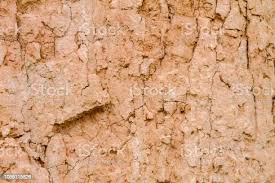

In [17]:
PIL.Image.open(str(train_data+'/clay/'+'images (58).jpg'))

In [18]:
batch_size = 32
img_height = 150
img_width = 150

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 210 files belonging to 4 classes.
Using 168 files for training.


In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 210 files belonging to 4 classes.
Using 42 files for validation.


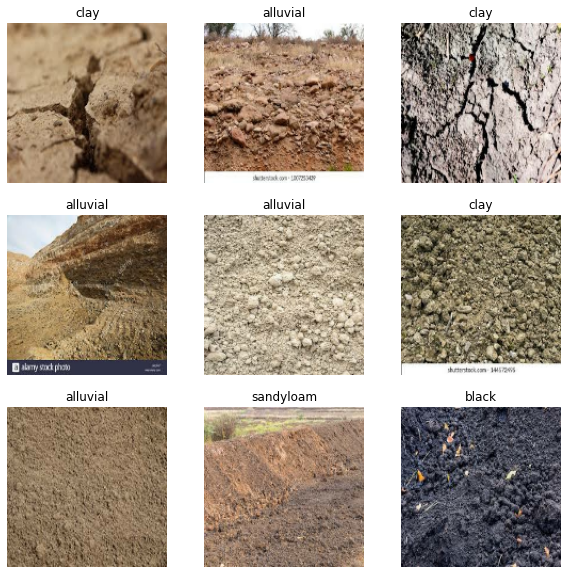

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [42]:
AUTOTUNE =tf.data.experimental.AUTOTUNE # tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [44]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [49]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)       

In [53]:
epochs=7
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
6/6 [==============================] - 8s 1s/step - loss: 1.1701 - accuracy: 0.3988 - val_loss: 1.1567 - val_accuracy: 0.3810
Epoch 2/7
6/6 [==============================] - 8s 1s/step - loss: 1.1003 - accuracy: 0.3869 - val_loss: 1.2222 - val_accuracy: 0.5000
Epoch 3/7
6/6 [==============================] - 7s 1s/step - loss: 1.0504 - accuracy: 0.4524 - val_loss: 1.1855 - val_accuracy: 0.2381
Epoch 4/7
6/6 [==============================] - 8s 1s/step - loss: 0.9925 - accuracy: 0.5952 - val_loss: 1.0787 - val_accuracy: 0.5952
Epoch 5/7
6/6 [==============================] - 8s 2s/step - loss: 0.9641 - accuracy: 0.5536 - val_loss: 1.1910 - val_accuracy: 0.3571
Epoch 6/7
6/6 [==============================] - 8s 1s/step - loss: 0.9043 - accuracy: 0.6071 - val_loss: 1.1017 - val_accuracy: 0.5476
Epoch 7/7
6/6 [==============================] - 8s 1s/step - loss: 0.8638 - accuracy: 0.5833 - val_loss: 1.2681 - val_accuracy: 0.4762


In [54]:
### save model
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
######################################################## testing ###################################################################

In [56]:
img = keras.preprocessing.image.load_img(
   train_data+'/clay/'+'images (58).jpg', target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to clay with a 56.83 percent confidence.


In [ ]:
###########################################################################################3!

In [1]:
!ls

In [ ]:
mv saved_model/my_model/saved_model.pb ./

In [66]:
import tarfile
model_name = "model.tar.gz"
with tarfile.open(model_name, "w:gz") as tar:
    for file in ("saved_model.pb", "variables"):
        tar.add(file)

In [69]:
api_key = '9PWTEYC3dF-_sx4gkKRR-iGDUv6mqnxH1XHtMxFAnnIx'
location = 'us-south'

In [70]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

In [71]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

In [72]:
space_id = '63bdf046-5b5d-4844-a618-5742170eda37'

In [73]:
client.spaces.list(limit=10)

------------------------------------  --------------  ------------------------
ID                                    NAME            CREATED
63bdf046-5b5d-4844-a618-5742170eda37  Deploy_crops_2  2021-07-27T03:12:01.716Z
------------------------------------  --------------  ------------------------


In [74]:
client.set.default_space(space_id)

'SUCCESS'

In [ ]:
#############################################################################################

In [81]:
import json

In [76]:
software_spec_uid = client.software_specifications.get_uid_by_name('tensorflow_2.4-py3.7')

In [77]:
model_meta_props = {client.repository.ModelMetaNames.NAME: "soil_prediction",
                    client.repository.ModelMetaNames.TYPE: "tensorflow_2.4",
                    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
                    }

In [78]:
published_model_details = client.repository.store_model(model='model.tar.gz', meta_props=model_meta_props)
model_uid = client.repository.get_model_uid(published_model_details)

In [79]:
model_details = client.repository.get_details(model_uid)

In [82]:
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "software_spec": {
      "id": "65e171d7-72d1-55d9-8ebb-f813d620c9bb",
      "name": "tensorflow_2.4-py3.7"
    },
    "type": "tensorflow_2.4"
  },
  "metadata": {
    "created_at": "2021-07-27T14:25:59.046Z",
    "id": "0a6ca700-cff4-4f4c-ae55-db115925ddd4",
    "modified_at": "2021-07-27T14:26:01.766Z",
    "name": "soil_prediction",
    "owner": "IBMid-664002A2CT",
    "space_id": "63bdf046-5b5d-4844-a618-5742170eda37"
  },
  "system": {
    "warnings": []
  }
}


In [83]:
deployment = client.deployments.create(model_uid, meta_props={
                                            client.deployments.ConfigurationMetaNames.NAME:"soil predicition",
                                            client.deployments.ConfigurationMetaNames.ONLINE:{}})

Deployment creation failed. Error: 402. {"trace":"22e99af0cf99366b369bbe6e3e9380bd","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}


{"trace":"22e99af0cf99366b369bbe6e3e9380bd","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}


--------------------------
Deployment creation failed
--------------------------




WMLClientError: Deployment creation failed. Error: 402. {"trace":"22e99af0cf99366b369bbe6e3e9380bd","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}